К текущему моменту мы научились обучать простейшую линейную регрессию: причем научились пользоваться как готовыми методами из sklearn, так и реализовывать поиск решения оптимальных коэффициентов самостоятельно с помощью градиентного спуска.

На последних занятиях мы узнали, что на практике часто приходится прибегать к некоторым хитростям, чтобы оценить, действительно ли модель отлично справляется со своей главной задачей - делать хорошие предсказания на новых данных в будущем, или, как еще говорят, в проде - после запуска.

Для этого было введено понятие так называемой обобщающей способности модели. Оно помогает нам оценить, насколько наша модель подогналась под увиденные данные и насколько она окажется хороша на новых данных.

Обобщающую способность мы научились оценивать с помощью метода Кросс-Валидации.



Построим для старой задачи с предсказанием длительности поездки в такси 2 модели линейной регрессии. Для каждой из них замерим качество на кросс-валидации и на тесте, заранее его отложив.

Считается, что если для K-Fold Кросс-Валидации брать большие значения K (то есть большое количество сплитов для разбиения тренировочной выборки на тренировку-валидацию), то оценка среднеквадратической ошибки будет получаться более справедливой. Так, например, когда K оказывается максимальным, а именно равным количеству объектов в выборке (каждый раз в валидации у нас 1 новый объект), то такой метод Кросс-Валидации еще называют LeaveOneOut.

Главная причина, почему мало где его используют, состоит в дороговизне такого метода. Например, в данной задаче в TAXI_train.csv лежит почти 1,2 млн. объектов. Тогда, чтобы замерить качество на LeaveOneOut валидации, нам пришлось бы обучить 1,2 млн. различных версий одной модели, что, конечно, не вписыватеся в рамки адекватного времени и прочих ресурсов.

Поэтому выберем компромиссное значение в виде 20 фолдов для K-Fold Кросс-Валидации.

Внимание! Для каждой из 2 моделей очевидно было бы справедливым замерять качество на тех же самых объектах, поэтому сплиты лучше зафиксировать сразу.

P.S. Оптимизировать будем MSLE метрику. И сравнивать модели тоже будем по ней будем. Как из домашнего задания про метрики, только без корня! :)

$$\text{MSLE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2$$


### Модель №1 Для начала посчитаем ошибку на Кросс-Валидации и Тесте для нашей самой базовой модели до вычленения каких-либо признаков, а просто взяв все вещественные колонки.

In [66]:
import pandas as pd

In [67]:
data = pd.read_csv('Data/initial_data.csv')
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455.0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663.0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124.0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429.0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435.0


In [68]:
data.store_and_fwd_flag.value_counts()

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64

In [69]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 111.3+ MB


In [71]:
data.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

In [72]:
data.drop(['id', 'vendor_id', 'store_and_fwd_flag', 'pickup_datetime'], inplace=True, axis=1)
data.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,1,-73.982155,40.767937,-73.964630,40.765602,455.0
1,1,-73.980415,40.738564,-73.999481,40.731152,663.0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124.0
3,1,-74.010040,40.719971,-74.012268,40.706718,429.0
4,1,-73.973053,40.793209,-73.972923,40.782520,435.0


In [73]:
data.dtypes

passenger_count        int64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_duration        float64
dtype: object

<Axes: >

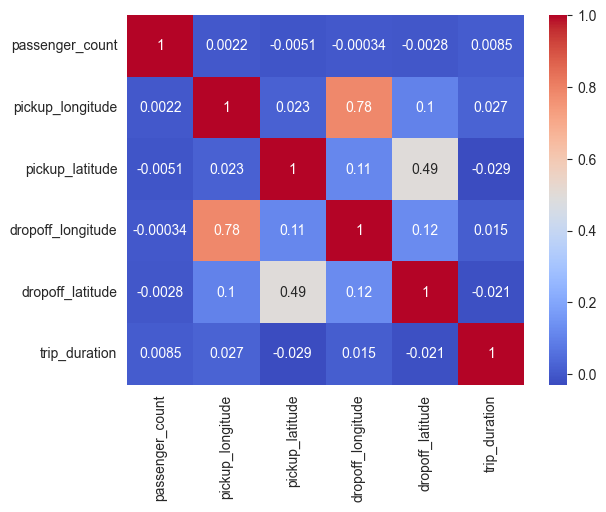

In [75]:
import seaborn as sns

sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

In [77]:
initial_data = pd.read_csv('Data/initial_data.csv', index_col='id')

initial_cols = ['vendor_id', 'passenger_count', 'pickup_longitude',
                'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                'trip_duration']

initial_data = initial_data[initial_cols]

### ТрюК!

In [80]:
### Замерять будем MSLE. Можно показать, что для оптимизации MSLE,
### Достаточно логарифмировать таргетную переменную, 
### а потом оптимизировать привычные MSE
import numpy as np

initial_data = initial_data.assign(log_trip_duration=np.log1p(initial_data['trip_duration']))
initial_data = initial_data.drop('trip_duration', axis=1)

In [82]:
initial_data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration
id,,,,,,,
id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,6.122493
id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,6.498282
id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,7.661527
id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,6.063785
id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,6.077642


### Объяснение:

Пусть имеем модель $a(x)$, обученную на MSE от $y$:
$$
\text{MSE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(y_i - a(x_i)\big)^2 \rightarrow min
$$

Также представим модель $a^*(x)$, обученную на MSE от $\log{(y + 1)}$:
$$
\text{MSE}(X, \log{(y+1)}, a^*) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - a^*(x_i)\big)^2 \rightarrow min
$$

Так как вторая модель старается аппроксимироваться ответы в виде $a^*(x) \approx \log{(y+1)}$, то для того, чтобы получить изначальные таргеты, необходимо выходы $a^*(x)$ проэкспоненцировать в виде следующего отношения: $a(x) = e^{a^*(x)} - 1$, то есть $a^*(x) = \log{(a(x) + 1)}$, где $a^*(x)$ дает логарифмические выходы, а $a(x)$ - изначальные. Подставим данное соотношение в MSE выше, получим:

$$
\text{MSE}(X, \log{(y+1)}, \log{(a(x) + 1)}) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$

А это в точности MSLE от $y$:

$$
\text{MSLE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$

In [123]:
### Выделим test

from sklearn.model_selection import train_test_split

X = initial_data.drop('log_trip_duration', axis=1)
y = initial_data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
### Применим K-Fold на оставшуюся валидационную часть X_train, y_train

from sklearn.model_selection import KFold

splitter = KFold(n_splits=20, shuffle=True, random_state=33)

In [125]:
### Замерьте качество на кросс-валидации!
### Your code is here
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

losses_test = []

for train_index, test_index in splitter.split(X_train):
    X_train_train, X_train_test = X_train.values[train_index], X_train.values[test_index]
    Y_train_train, Y_train_test = y_train.values[train_index], y_train.values[test_index]

    model = LinearRegression()
    model.fit(X_train_train, Y_train_train)

    losses_test.append(mean_squared_error(y_true=Y_train_test, y_pred=model.predict(X_train_test)))

In [126]:
np.mean(losses_test)

0.6134219105328516

In [130]:
### Теперь построим модель на всей тренировочной выборке
### и замерим качество на тесте!
### Your code is here

model = LinearRegression()
model.fit(X_train, y_train)
mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))

0.6056668879526188

In [134]:
### Укажите в ответе на задание 4 среднее качество моделей на валидационных выборках
### и качество модели, обученной на полной тренировочной выборке, на тестовой выборке.
### В качестве разделителя используйте точку, ответ округлите до тысячных.

### Модель №2. Проделаем все то же самое, только для модели с более осознанными признаками, которые удалось получить ранее

In [138]:
processed_data = pd.read_csv('Data/processed_data.csv', index_col='id')

In [139]:
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance_km
id,,,,,
id2875421,1,930.399753,0,455.0,1.500479
id2377394,0,930.399753,0,663.0,1.807119
id3858529,1,930.399753,0,2124.0,6.392080
id3504673,1,930.399753,0,429.0,1.487155
id2181028,1,930.399753,0,435.0,1.189925


In [140]:
### Замерять будем MSLE. Можно показать, что для оптимизации MSLE,
### Достаточно логарифмировать таргетную переменную, 
### а потом оптимизировать привычные MSE
import numpy as np

processed_data = processed_data.assign(log_trip_duration=np.log1p(processed_data['trip_duration']))
processed_data = processed_data.drop('trip_duration', axis=1)

In [141]:
X_2 = processed_data.drop('log_trip_duration', axis=1)
y_2 = processed_data['log_trip_duration']

In [142]:
### Важно! Когда сравниваем модели по их качеству
### на валидации и на тесте, не шаффлим данные заново!

test_indexes = X_test.index
train_indexes = X_train.index

X_train_2 = X_2[X_2.index.isin(train_indexes)]
y_train_2 = y_2[y_2.index.isin(train_indexes)]

X_test_2 = X_2[X_2.index.isin(test_indexes)]
y_test_2 = y_2[y_2.index.isin(test_indexes)]

In [150]:
### Замерьте качество на кросс-валидации!
### Your code is here
losses_test = []

for train_index, test_index in splitter.split(X_train_2):
    X_train_train, X_train_test = X_train_2.values[train_index], X_train_2.values[test_index]
    Y_train_train, Y_train_test = y_train_2.values[train_index], y_train_2.values[test_index]

    model = LinearRegression()
    model.fit(X_train_train, Y_train_train)

    losses_test.append(mean_squared_error(y_true=Y_train_test, y_pred=model.predict(X_train_test)))

np.mean(losses_test)

0.4313257704232938

In [162]:
### Теперь построим модель и замерим качество на тесте!
### Your code is here
model = LinearRegression()
model.fit(X_train_2, y_train_2)
mean_squared_error(y_true=y_test_2, y_pred=model.predict(X_test_2))

0.4074669546810228

In [ ]:
### Укажите в ответе на задание 5 среднее качество моделей на валидационных выборках
### и качество модели, обученной на полной тренировочной выборке, на тестовой выборке.
### В качестве разделителя используйте точку, ответ округлите до тысячных.

### Какую модель среди двух стоило бы выбрать? Помогла ли нам базовая обработка признаков с первых уроков? 